<a href="https://colab.research.google.com/github/kumarsourav3/NLPlay-with-Transformer/blob/main/LSTM_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib as  plt
from google.colab import drive
drive.mount('/content/gdrive')



Mounted at /content/gdrive


In [5]:
cd '/content/gdrive/My Drive/nlp'

/content/gdrive/My Drive/nlp


In [6]:
pwd

'/content/gdrive/My Drive/nlp'

In [7]:
df=pd.read_csv('IMDB Dataset.csv')

In [8]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [9]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [10]:
df['sentiment'].describe()

count        50000
unique           2
top       negative
freq         25000
Name: sentiment, dtype: object

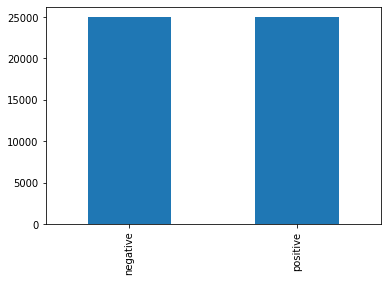

In [11]:
pd.value_counts(df['sentiment']).plot.bar()

In [12]:
def map_sentiment(x):
  if x=="negative":
    return 0
  else: return 1

In [13]:
df['sentiment']=[map_sentiment(x) for x in df['sentiment']]

In [14]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

## **Text preprocessing**

In [15]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Removing punctuations and tokenizing the words.**

In [16]:
tokenizer=nltk.RegexpTokenizer(r"\w+")

In [17]:
for i in range(50000):
  df['review'][i]=tokenizer.tokenize(df['review'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Removing stopwords**

In [18]:
stop_words=set(stopwords.words('english'))

In [19]:
df['review']=df['review'].apply(lambda x: [item for item in x if item not in stop_words])

In [20]:
from nltk.stem import PorterStemmer
stemming=PorterStemmer()

**Stemming**

In [21]:
def stem_list(row):
    my_list = row['review']
    stemmed_list = [stemming.stem(word) for word in my_list]
    return (stemmed_list)

df['review'] = df.apply(stem_list, axis=1)

In [22]:
df['review'].describe()

count                                                 50000
unique                                                49577
top       [love, today, show, It, varieti, sole, cook, w...
freq                                                      5
Name: review, dtype: object

# **Making dictionary**

In [23]:
from collections import Counter

In [24]:
words=Counter()
for i in range(50000):
  for word in df['review'][i]:
    words.update([word.lower()])

In [25]:
len(words)

71583

In [26]:
words={k:v for (k,v) in words.items() if v>1}

In [27]:
len(words)

43025

In [28]:
words['_PAD']=0
words['_UNK']=0

In [29]:
words=sorted(words, key=words.get, reverse=True)

In [30]:
len(words)

43027

In [31]:
w2idx= {o:i for i,o in enumerate(words)}

# **Indexing words from dictionary**

In [32]:
for i in range(50000):
  df['review'][i]=[w2idx[word] if word in w2idx else 0 for word in  df['review'][i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# **Padding the sequence**

In [33]:
def pad_input(sentences, seq_size):
    features=np.zeros((len(sentences), seq_size), dtype=int)
    for ii, word in enumerate(sentences):
      if len(word)!=0:
        features[ii, -len(word):] = np.array(word)[ :seq_size]
    return features


In [34]:
df

,review,sentiment
0,"[5, 262, 387, 15, 257, 0, 210, 1680, 136, 123,...",1
1,"[0, 120, 60, 227, 0, 0, 4, 3, 1673, 13010, 83,...",1
2,"[0, 106, 120, 36, 711, 8, 831, 1389, 2281, 468...",1
3,"[426, 144, 60, 230, 2906, 33, 561, 3213, 623, ...",0
4,"[0, 8202, 30, 8, 232, 553, 1164, 3, 15, 0, 820...",1
...,...,...
49995,"[0, 106, 2, 123, 9, 216, 0, 1159, 104, 32, 166...",1
49996,"[26, 46, 26, 361, 26, 34, 1138, 109, 485, 1430...",0
49997,"[0, 2822, 3743, 21989, 6558, 325, 3766, 3743, ...",0
49998,"[0, 29, 2489, 913, 353, 392, 7886, 5, 10, 238,...",0


# **Splitting the train and test sets**

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test=train_test_split(df['review'],df['sentiment'],test_size=0.3, random_state=15)

In [36]:
X_train_pad= pad_input(X_train, 200)
X_test_pad=pad_input(X_test,200)

In [37]:
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

**Import lstm modules from pytorch**

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [83]:
train_data= TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(Y_train))
test_data= TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(Y_test))

In [84]:
batch_size=400

In [85]:
train_loader= DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader= DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [86]:
is_cuda=torch.cuda.is_available()
if is_cuda:
  device=torch.device("cuda")
else: device=torch.device("cpu")

In [87]:
device

device(type='cuda')

# **Building the model**



In [92]:
class SentimentNet(nn.Module):
    def __init__(self,vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
      super(SentimentNet, self).__init__()
      self.output_size = output_size
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim

      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.lstm=nn.LSTM(embedding_dim,hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
      self.dropout=nn.Dropout(drop_prob)
      self.fc= nn.Linear(hidden_dim, output_size)
      self.sigmoid= nn.Sigmoid()

    def forward(self, x, hidden):
      batch_size= x.size(0)
      x=x.long()
      embeds= self.embedding(x)
      lstm_out, hidden= self.lstm(embeds, hidden)
      lstm_out= lstm_out.contiguous().view(-1, self.hidden_dim)

      out= self.dropout(lstm_out)
      out =self.fc(out)
      out= self.sigmoid(out)

      out= out.view(batch_size, -1)
      out=out[:, -1]
      return out, hidden
    
    def init_hidden(self, batch_size):
      weight= next(self.parameters()).data
      hidden= (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(), 
                 weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
      return hidden



In [93]:
vocab_size= len(w2idx)+1
output_size= 1
embedding_dim= 400
hidden_dim = 512
n_layers=2

model= SentimentNet(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
model.to(device)

lr=0.005
criterion= nn.BCELoss()
optimizer= torch.optim.Adam(model.parameters(), lr=lr)


## **Training**

In [112]:
epochs=3
counter=0
clip=5
print_every=1000
loss_at_epoch=[]
for i in range(epochs):
    train_losses=[]
    train_acc=0
    model.train()
    h=model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        counter+=1
        h= tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h= model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        train_losses.append(loss.item())
        pred= torch.round(output.squeeze())
        train_acc += torch.sum(pred == labels.squeeze()).item()
        num_train_correct=np.sum(correct)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
    epoch_loss = np.mean(train_losses)
    loss_at_epoch.append(epoch_loss)
  #accuracy at the end of one epoch
    epoch_acc = train_acc/len(train_loader.dataset)
    print('Epoch :'+str(i+1))
    print('loss = '+str(epoch_loss))
    print("accuracy = "+str(epoch_acc))




Epoch :1
loss = 0.031648966874499085
accuracy = 0.9836285714285714
Epoch :2
loss = 0.014329641840645465
accuracy = 0.9896571428571429
Epoch :3
loss = 0.013316382213773998
accuracy = 0.9899142857142857


# **Testing**

In [113]:

test_loss = []
test_acc = 0
model.eval() 
for inputs,labels in test_loader:
    h = tuple(e.data for e in h)
    inputs,labels = inputs.to(device),labels.to(device)
    # calculating the output
    output,h = model(inputs,h)
    loss = criterion(output.squeeze(),labels.float())
    test_loss.append(loss.item())
    prediction = torch.round(output.squeeze())
    test_acc += torch.sum(prediction == labels.squeeze()).item()
loss = np.mean(test_loss)
accuracy = test_acc/len(test_loader.dataset)
print('loss'+str(loss))
print('test accuracy'+str(accuracy))

loss0.7420661240010649
test accuracy0.8534
